In [1]:
import matplotlib.pyplot as plt
import torch
from typing import List
import pandas as pd

import nnts
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.data.preprocessing as preprocessing
import nnts.torch.models
import nnts.torch.models.trainers as trainers
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
import covs 

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
metadata = nnts.data.loader.load_metadata('weather',path='informer.json')

In [3]:
df_orig = pd.read_csv(metadata.path)

In [4]:
df_orig = df_orig.rename({"WetBulbCelsius": "y", "date": "ds"}, axis="columns")

In [5]:
df_orig["unique_id"] = "T1"

In [6]:
import scipy

In [7]:
cols = df_orig.columns.tolist()
cols.remove("ds")
cols.remove("unique_id")
cols.remove("y")

In [8]:
for i in range(len(cols)):
    pearson = scipy.stats.pearsonr(df_orig["y"], df_orig[cols[i]])
    print(cols[i], pearson[0])

Visibility 0.1727168973441378
DryBulbFarenheit 0.9292496536925701
DryBulbCelsius 0.9335993557413845
WetBulbFarenheit 0.986069702539343
DewPointFarenheit 0.7896582660705951
DewPointCelsius 0.7902989845876875
RelativeHumidity -0.20855812611334734
WindSpeed 0.01073979632938904
WindDirection -0.0031770345339278867
StationPressure 0.5526030687505663
Altimeter 0.5521352614575419


"Visibility" 24 / 0.27  
"StationPressure" 34 / 0.68  
"Altimeter" 34 / 0.68  
"WindDirection" 12 / -0.175  
"RelativeHumidity" 24 / -0.26  
"WindSpeed" 36 / -0.12  

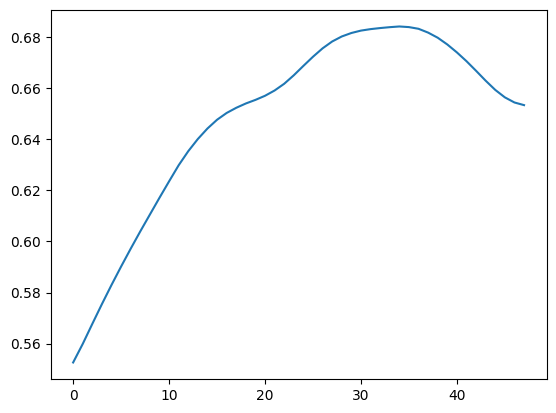

In [9]:
pearson_list = []
for i in range(48):
    pearson = scipy.stats.pearsonr(
        df_orig["y"], df_orig.shift(i).bfill()["StationPressure"]
    )
    pearson_list.append(pearson[0])
plt.plot(pearson_list)

In [10]:
df_orig["y_lead_1"] = df_orig["StationPressure"].shift(35)

In [11]:
trn_length = int(24 * 365.25 * 2)
val_test_length = int(24 * 365.25 * (10 / 12))

In [12]:
params = nnts.models.Hyperparams()
model_name = "seg-lstm"
PATH = f"results/{model_name}/{metadata.dataset}"

In [13]:
scenario_list: List[nnts.experiments.CovariateScenario] = []

# Add the baseline scenarios
# for seed in [42, 43, 44, 45, 46]:
#    scenario_list.append(
#        nnts.experiments.CovariateScenario(metadata.prediction_length, error=0.0, covariates=0, seed=seed)
#    )


scenario_list = [
    nnts.experiments.CovariateScenario(
        metadata.prediction_length, error=0.0, covariates=1, seed=42
    ),
    nnts.experiments.CovariateScenario(1, error=0.0, covariates=1, seed=42),
    nnts.experiments.CovariateScenario(1, error=0.0, covariates=0, seed=42),
]
scenario_list = [
    nnts.experiments.CovariateScenario(
        metadata.prediction_length, error=0.0, covariates=0, seed=42
    )
]

In [14]:
def prepare(data, scenario):
    pearson = 0
    conts = []
    noise = 0
    if scenario.covariates > 0:
        pearson = covs.calculate_pearson(data)
        conts.append("y_lead_1")
    data = data.dropna()
    scenario.conts = conts
    scenario.pearson = pearson
    scenario.noise = noise
    return data, scenario

In [16]:
for scenario in scenario_list:
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df, scenario = prepare(df_orig.copy(), scenario)
    split_data = nnts.data.splitter.split_dataframe(
        df_orig, trn_length, val_test_length, val_test_length
    )
    trn_dl, val_dl, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    name = f"cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{str(scenario.prediction_length)}-seed-{scenario.seed}"
    logger = nnts.loggers.ProjectRun(
        nnts.loggers.JsonFileHandler(
            path=PATH, filename=f"{name}.json"
        ),
        #nnts.loggers.PrintHandler(),
        project=f"{model_name}-{metadata.dataset}",
        run=name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
    )

    net = nnts.torch.models.SegLSTM(
        nnts.torch.models.LinearModel,
        params,
        preprocessing.masked_mean_abs_scaling,
        scenario.covariates + 1,
        24
    )
    trner = trainers.TorchEpochTrainer(
        nnts.models.TrainerState(), 
        net, 
        params, 
        metadata, 
        f"{PATH}/{name}.pt",
        logger=logger
    )
    evaluator = trner.train(trn_dl, val_dl)
    y_hat, y  = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

SegLSTM(
  (decoder): SegLSTMDecoder(
    (rnn): LSTM(24, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=24, bias=True)
    )
  )
)
Artifact saved to results/seg-lstm/weather/cov-0-pearsn-0-pl-168-seed-42.pt
{'train_loss': 4.067863464355469, 'valid_loss': 2.3662703037261963, 'elapsed_time': 61.784616250079125}
Artifact saved to results/seg-lstm/weather/cov-0-pearsn-0-pl-168-seed-42.pt
{'train_loss': 2.1368985176086426, 'valid_loss': 2.027615547180176, 'elapsed_time': 63.74254266615026}
Artifact saved to results/seg-lstm/weather/cov-0-pearsn-0-pl-168-seed-42.pt
{'train_loss': 1.8440334796905518, 'valid_loss': 1.7791988849639893, 'elapsed_time': 62.52647987497039}
{'train_loss': 1.2325080633163452, 'valid_loss': 1.9764845371246338, 'elapsed_time': 65.03935170802288}
{'train_loss': 0.5580490231513977, 'v

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


In [6]:
scenario_list = [
    nnts.experiments.CovariateScenario(
        1, 0, conts=[], pearson=1, noise=0, covariates=0
    ),
    nnts.experiments.CovariateScenario(
        2, 0, conts=[], pearson=1, noise=0, covariates=0
    ),
    nnts.experiments.CovariateScenario(
        3, 0, conts=[], pearson=1, noise=0, covariates=0
    ),
]

In [57]:
scenario_list = [
    #nnts.experiments.CovariateScenario(
    #    metadata.prediction_length, error=0.0, covariates=1, seed=42
    #),
    nnts.experiments.CovariateScenario(
        metadata.prediction_length, error=0.0, covariates=0, seed=42
    ),
]

In [39]:
for scenario in scenario_list:
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df, scenario = covs.prepare(df_orig.copy(), scenario)
    split_data = nnts.data.splitter.split_dataframe(
        df_orig, trn_length, val_test_length, val_test_length
    )
    _, _, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    name = f"cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{str(scenario.prediction_length)}-seed-{scenario.seed}"
    logger = nnts.loggers.ProjectRun(
        nnts.loggers.JsonFileHandler(
            path=PATH, filename=f"{name}.json"
        ),
        #nnts.loggers.PrintHandler(),
        project=f"{model_name}-{metadata.dataset}",
        run=name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
    )

    net = nnts.torch.models.BaseLSTM(
    nnts.torch.models.LinearModel,
    params,
    preprocessing.masked_mean_abs_scaling,
    1,
)
    best_state_dict = torch.load(
        f"{PATH}/cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{metadata.prediction_length}-seed-{scenario.seed}.pt"
    )
    net.load_state_dict(best_state_dict)
    evaluator = nnts.torch.models.trainers.TorchEvaluator(net)
    y_hat, y  = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

{'mse': 4.979427, 'mae': 1.4757146835327148, 'mape': inf, 'smape': 0.5394078493118286, 'abs_error': 256845.17, 'mase': 0.80914056, 'rmse': 1.7634273767471313}
Run cov-0-pearsn-0-pl-24-seed-42 finished


/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


In [19]:
csv_aggregator = covs.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

ValueError: can only convert an array of size 1 to a Python scalar

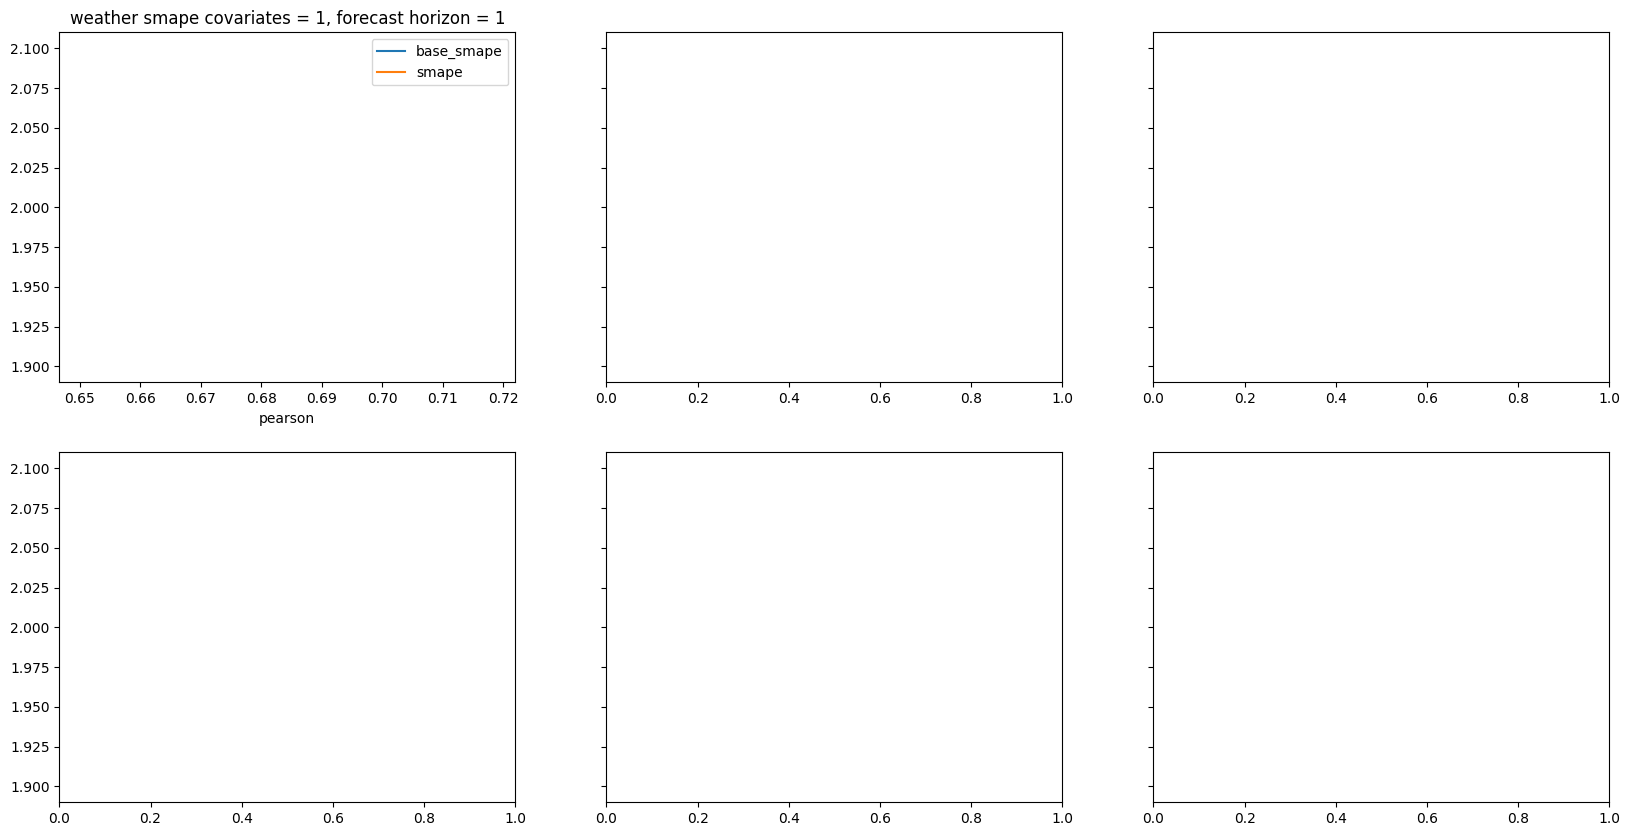

In [26]:
#results = pd.read_csv(f"{PATH}/results.csv")

for metric in ["smape", "mape", "rmse", "mae"]:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharey=True)
    covs.get_chart_data(results, 1, 1, metric).plot(
        kind="line",
        ax=axes[0, 0],
        title=f"{metadata.dataset} {metric} covariates = 1, forecast horizon = 1",
    )
    covs.get_chart_data(results, 2, 2, metric).plot(
        kind="line",
        ax=axes[0, 1],
        title=f"{metadata.dataset} {metric} covariates = 2, forecast horizon = 2",
    )
    covs.get_chart_data(results, 3, 3, metric).plot(
        kind="line",
        ax=axes[0, 2],
        title=f"{metadata.dataset} {metric} covariates = 3, forecast horizon = 3",
    )
    covs.get_chart_data(results, metadata.prediction_length, 1, metric).plot(
        kind="line",
        ax=axes[1, 0],
        title=f"{metadata.dataset} {metric} covariates = 1, forecast horizon = {metadata.prediction_length}",
    )
    covs.get_chart_data(results, metadata.prediction_length, 2, metric).plot(
        kind="line",
        ax=axes[1, 1],
        title=f"{metadata.dataset} {metric} covariates = 2, forecast horizon = {metadata.prediction_length}",
    )
    covs.get_chart_data(results, metadata.prediction_length, 3, metric).plot(
        kind="line",
        ax=axes[1, 2],
        title=f"{metadata.dataset} {metric} covariates = 3, forecast horizon = {metadata.prediction_length}",
    )
    fig.tight_layout()
    fig.savefig(f"{PATH}/{metric}.png")

<Axes: >

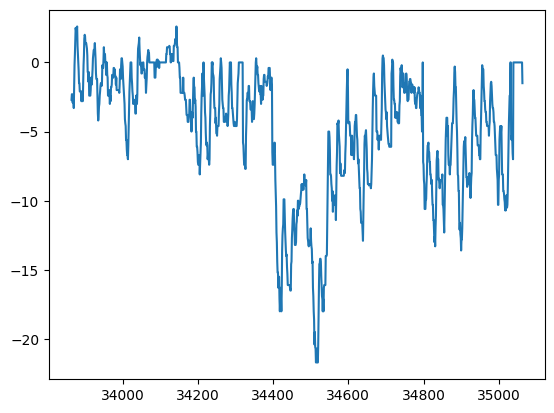

In [67]:
df.tail(metadata.prediction_length*50)['y'].plot()

/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_7522/396367859.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["y_check"] = y.squeeze()
/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_7522/396367859.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["y_hat"] = y_hat.squeeze()


<Axes: xlabel='ds'>

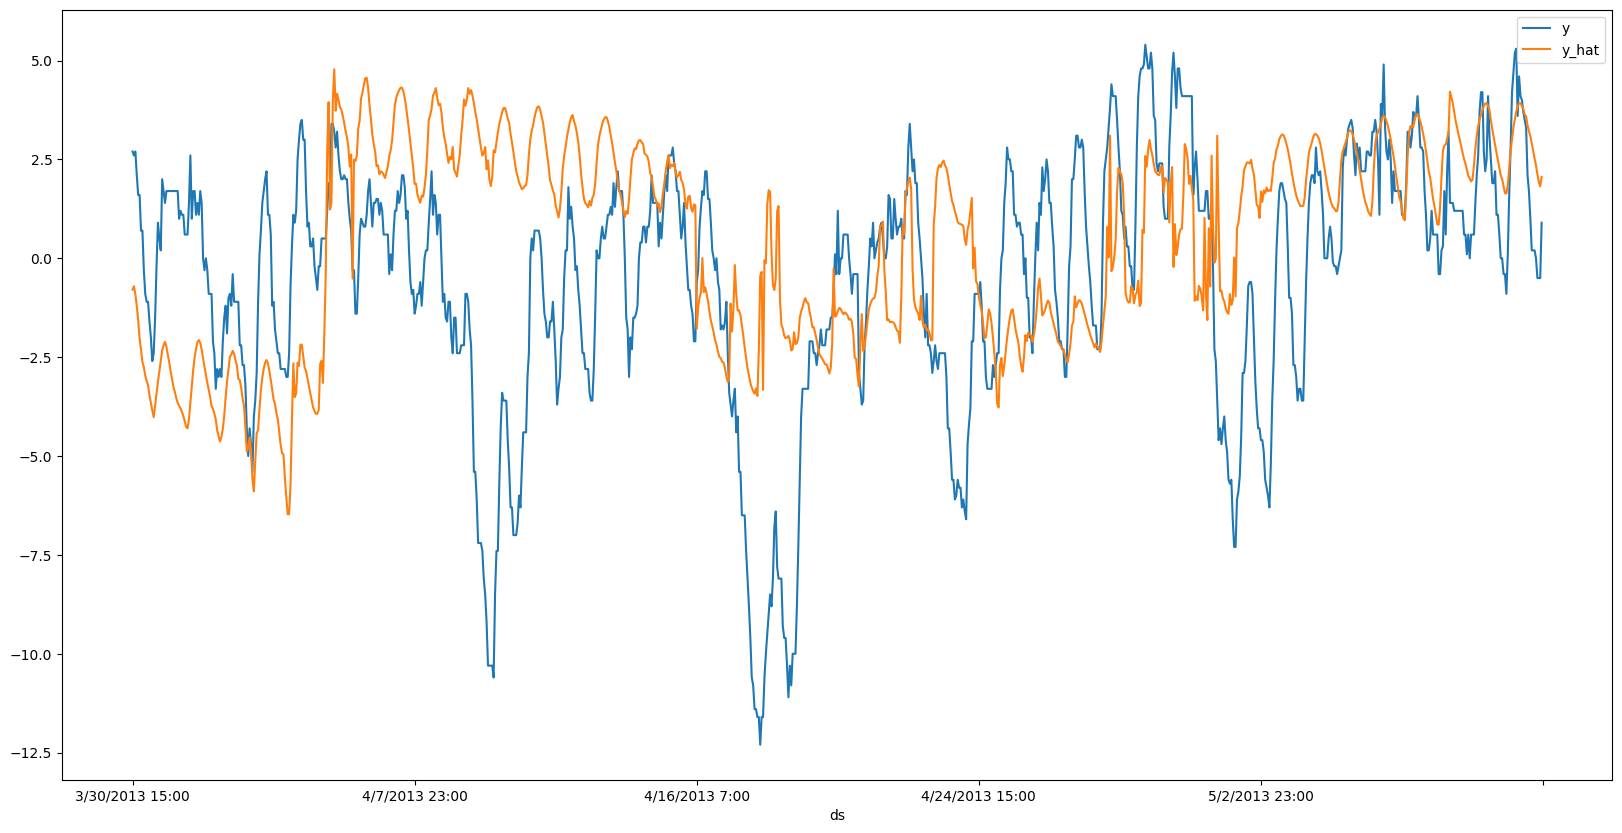

In [22]:
y_hat = y_hat[:, -1:, ...]
y = y[:, -1:, ...]
df_test = df.tail(y_hat.shape[0])
df_test["y_check"] = y.squeeze()
df_test["y_hat"] = y_hat.squeeze()
df_test[["y", "y_check", "y_hat"]]
df_test.set_index('ds')[['y','y_hat']].iloc[0:1000].plot(figsize=(20,10))

In [18]:
results.loc[(results['covariates']==0) & (results['prediction_length']==metadata.prediction_length),['smape', 'mape', 'rmse', 'mae']].mean()

NameError: name 'results' is not defined

In [20]:
test_metrics = nnts.metrics.calc_metrics(y, y_hat, metadata.freq, metadata.seasonality)
test_metrics

/Users/garethdavies/Development/workspaces/nnts/venv/lib/python3.11/site-packages/gluonts/evaluation/metrics.py:116: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(target - forecast) / np.abs(target))


{'mse': 15.194205,
 'mae': 2.964280366897583,
 'mape': inf,
 'smape': 0.8105424642562866,
 'abs_error': 19662.072,
 'mase': 1.674381,
 'rmse': 2.964280366897583}

In [27]:
mean, std = df_orig['y'].mean(), df_orig['y'].std()

In [31]:
(test_metrics['mae'] - mean) / std, (test_metrics['mse'] - mean) / std

(0.280965488742196, 2.0538412200967975)

In [30]:
scenario.prediction_length

168